In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.linalg import svd

import grakel as gk
from grakel.kernels import WeisfeilerLehman
from grakel.utils import graph_from_networkx
from netrd.distance import Frobenius
from netrd.distance import JaccardDistance
from netrd.distance import DeltaCon

In [5]:
with open('../graphs/exports_graphs.pkl', 'rb') as file:
    export_graphs = pkl.load(file)

In [11]:
def normalize_similarity(similarity):
    """
    Normalize similarity values between 0 and 1.
    """
    min_val = np.min(similarity)
    max_val = np.max(similarity)
    normalized_similarity = (similarity - min_val) / (max_val - min_val)
    return normalized_similarity

In [12]:
def pairwise_distance(graphs, dist_type):
    """
    Create pairwise matrix which contains the distance for every pair of graphs

    #Parameters
    graphs - list of graphs
    dist_type - specified distance function
    """
    i = len(graphs)
    distances = np.zeros(shape=(i,i))
    for i in range(len(graphs)):
        for j in range(len(graphs)):
            distances[i][j] = dist_type(graphs[i], graphs[j])
    return distances

In [13]:
def jaccard_distance(G1, G2):
    jacc = JaccardDistance()
    distance = jacc.dist(G1, G2)
    return distance

In [14]:
jaccard_distances = pairwise_distance(export_graphs, jaccard_distance)

In [15]:
def frobenius_distance(G1, G2):
    fro = Frobenius()
    distance = fro.dist(G1, G2)
    return distance

In [16]:
frobenius_distances = pairwise_distance(export_graphs, frobenius_distance)

In [17]:
frobenius_norm = normalize_similarity(np.array(frobenius_distances))

In [18]:
def deltacon_distance(G1, G2):
    dc = DeltaCon()
    distance = dc.dist(G1, G2)
    return distance

In [19]:
deltacon_distances_exports = pairwise_distance(export_graphs, deltacon_distance)
deltacon_norm = normalize_similarity(np.array(deltacon_distances_exports))

/Users/sinclaireschuetze/anaconda3/lib/python3.11/site-packages/netrd/utilities/graph.py:74: RuntimeWarning: Coercing directed graph to undirected.
  warnings.warn("Coercing directed graph to undirected.", RuntimeWarning)
<class 'networkx.utils.decorators.argmap'> compilation 4:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


In [20]:
for g in export_graphs:
    nx.set_node_attributes(g, 1, 'label')

# Assuming G1 and G2 are your graphs
G = graph_from_networkx(export_graphs, node_labels_tag='label')

# Initialize a Weisfeiler-Lehman kernel
gk = WeisfeilerLehman(normalize=True)

# Compute the kernel matrix
kernel_matrix = gk.fit_transform(G)

kernel_matrix = 1-kernel_matrix

## Average Similarity Statistic

In [21]:
def get_change_points(matrix, L):
    years = range(1962,2022)
    Z = []

    for t in range(L, len(years)):
        avg_sim = 0
        for i in range(1,L+1):
            avg_sim += matrix[t][t-i]
        Z.append(avg_sim/L)

    return Z

In [22]:
fro_change_points = get_change_points(frobenius_norm, 5)
wl_change_points = get_change_points(kernel_matrix, 5)
jacc_change_points = get_change_points(jaccard_distances, 5)
deltacon_change_point = get_change_points(deltacon_norm, 5)

In [69]:
def detect_change_points(distances):
    change_points = []
    years = range(1967,2022)
    for d in range(1,len(distances)):
        if distances[d-1] > 0.5 and distances[d]<= 0.5:
            change_points.append(years[d])

    return change_points

In [70]:
fro_binary = detect_change_points(fro_change_points)
wl_binary = detect_change_points(wl_change_points)
deltacon_binary = detect_change_points(deltacon_change_point)
jacc_binary = detect_change_points(jacc_change_points)

In [76]:
fro_binary

[2019]

In [75]:
fro_change_points

array([0.48942419, 0.42609057, 0.54520652, 0.60730995, 0.61152863,
       0.62036136, 0.63172306, 0.64846607, 0.61488045, 0.59468107,
       0.57585455, 0.60124354, 0.57473243, 0.58452778, 0.58454051,
       0.55872224, 0.57821339, 0.53320699, 0.5033136 , 0.6984562 ,
       0.7025549 , 0.70085562, 0.64542347, 0.68381873, 0.59210189,
       0.77581146, 0.79139836, 0.7570118 , 0.83808843, 0.80171617,
       0.72253197, 0.66857208, 0.74176722, 0.92538357, 0.82258006,
       0.73075376, 0.64241261, 0.56053889, 0.61874223, 0.75650384,
       0.69857958, 0.63677881, 0.58212703, 0.52173327, 0.97742854,
       0.90860595, 0.9506102 , 0.86915969, 0.76500114, 0.66314598,
       0.57549977, 0.50699495, 0.48577955, 0.93676968, 0.81918175])

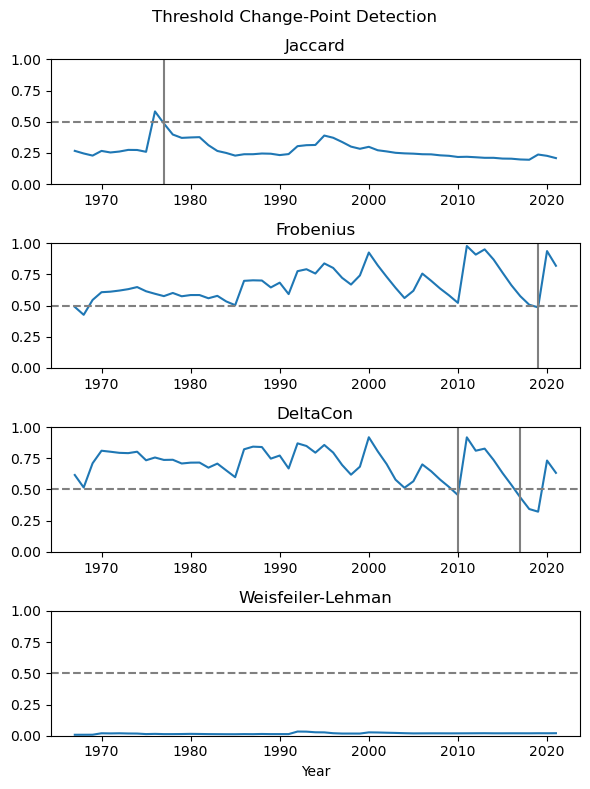

In [93]:
# Create a line graph of r_stat
l = 5

t_range = range(1962+l,2022)

fro_change_points = np.array(fro_change_points)
wl_change_points = np.array(wl_change_points)
jacc_change_points = np.array(jacc_change_points)
deltacon_change_point = np.array(deltacon_change_point)

fig, axs = plt.subplots(4, sharex=True, figsize=(6, 8))

axs[0].plot(t_range,jacc_change_points)
axs[0].set_title('Jaccard')
axs[0].axhline(0.5, color='grey', linestyle='--')
axs[0].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
for i in jacc_binary:
    axs[0].axvline(x=i, color='grey')

axs[1].plot(t_range,fro_change_points)
axs[1].set_title('Frobenius')
axs[1].axhline(0.5, color='grey', linestyle='--')
axs[1].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
for i in fro_binary:
    axs[1].axvline(x=i, color='grey')

axs[2].plot(t_range,deltacon_change_point)
axs[2].set_title('DeltaCon')
axs[2].axhline(0.5, color='grey', linestyle='--')
axs[2].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
for i in deltacon_binary:
    axs[2].axvline(x=i, color='grey')

axs[3].plot(t_range,wl_change_points)
axs[3].set_title('Weisfeiler-Lehman')
axs[3].axhline(0.5, color='grey', linestyle='--')
axs[3].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
for i in wl_binary:
    axs[3].axvline(x=i, color='grey')

for ax in axs:
    ax.set_ylim(0, 1)  # Set y-range from 0 to 1

plt.xlabel('Year')
plt.suptitle('Threshold Change-Point Detection')
plt.tight_layout()
plt.show()

## Window Methods

In [1]:
import dgl
import os
import sys
import pickle as pkl
import scipy.sparse as ss
from src.utils.functions import load_model, load_sequence, prepare_batches, add_features_dataset, normalise_statistics, dist_labels_to_changepoint_labels, dist_labels_to_changepoint_labels_adjusted
from src.utils.misc import get_device
from detect import compute_sgnn_similarity
from src.utils.baselines import laplacian_spectrum_similarity, NCPD, CUMSUM, CUMSUM_2, avg_deltacon_similarity, avg_wl_distance, avg_frobenius_distance, avg_procrustes_distance, \
    distance_procrustes_LE, evaluate_baseline
from src.utils.graphs import laplacian_embeddings, norm_laplacian, laplacian, degree_matrix
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy
import grakel
from grakel.kernels import WeisfeilerLehman, VertexHistogram
from src.utils.metrics import find_best_threshold, adjust_predicts_donut, binary_metrics_adj, best_f1_search_grid, compute_ari
from pathlib import PosixPath
from src.utils.functions import dist_labels_to_changepoint_labels
import json
import dgl

In [2]:
with open('../graphs/exports_graphs.pkl', 'rb') as file:
    data = pkl.load(file)

true_cps = [1962, 1967, 1973, 1978, 1981, 1989, 1993, 1996, 2002, 2007, 2012, 2014, 2016]

phases = []
p = 0
for i, g in enumerate(data):
    year = i+1962
    if year in true_cps and year != 1962:
        p += 1
        
    phases.append(p)

true_labels = dist_labels_to_changepoint_labels(phases)

In [3]:
lad, lad_times = laplacian_spectrum_similarity(data, window_length=6,normalize=True, n_eigen=3)
lad_times = [x+1962 for x in lad_times]

cusum, cusum_times = CUMSUM(data, window_length=6)
cusum_times = [x+1962 for x in cusum_times]

cusum_2, cusum_2_times = CUMSUM_2(data, window_length=6)
cusum_2_times = [x+1962 for x in cusum_2_times]

deltacon, dc_times = avg_deltacon_similarity(data, window_length=6,diff=True)
deltacon_times = [x+1962 for x in dc_times]

frobenius, fb_times = avg_frobenius_distance(data, window_length=6,diff=True)
fb_times = [x+1962 for x in fb_times]

wl_distance, wl_times = avg_wl_distance(data, window_length=6,diff=True)
wl_times = [x+1962 for x in wl_times]

In [4]:
lad_norm = normalise_statistics(lad)
cusum_norm = normalise_statistics(cusum)
cusum_2_norm = normalise_statistics(cusum_2)
deltacon_norm = normalise_statistics(deltacon)
frobenius_norm = normalise_statistics(frobenius)
wl_distance_norm = normalise_statistics(wl_distance)

Text(0.5, 0, '$t$')

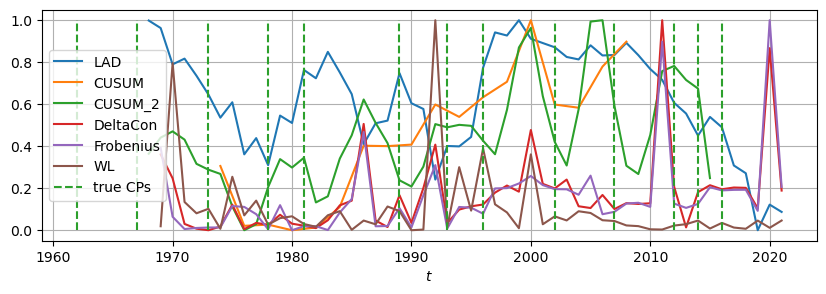

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10,3))
ax.plot(lad_times, lad_norm, label='LAD')
ax.plot(cusum_times, cusum_norm, label='CUSUM')
ax.plot(cusum_2_times, cusum_2_norm, label='CUSUM_2')
ax.plot(deltacon_times, deltacon_norm, label='DeltaCon')
ax.plot(fb_times, frobenius_norm, label='Frobenius')
ax.plot(wl_times, wl_distance_norm, label='WL')
ax.vlines(x=true_cps, ymin=0, ymax=1, linestyles='dashed', label='true CPs', color='tab:green')
ax.legend(loc='best')
ax.grid(visible=True)
ax.set_xlabel(rf'$t$')
#ax.set_ylabel(rf'$Z_t(s,L)$')

In [3]:
for method in ['lad', 'cusum', 'cusum_2', 'deltacon','frobenius', 'wl']:
    ari, f1 = evaluate_baseline(method, test_data=data, test_labels=true_labels, window_length=6, tolerance=3, n_eigen=4, diff=True)
    print("Method : ", method)
    print("F1 test and ARI test : ", f1, ari)

Method :  lad
F1 test and ARI test :  0.6363636363636364 0.4112066628884016
Method :  cusum
F1 test and ARI test :  0.47058823529411764 0.4320418802864127
Method :  cusum_2
F1 test and ARI test :  0.4 0.23608113940440226
Method :  deltacon
F1 test and ARI test :  0.6111111111111112 0.3203259525137632
Method :  frobenius
F1 test and ARI test :  0.0 0.04867502583441037
Method :  wl
F1 test and ARI test :  0.0 0.1287824668442926
